# CIFAR10 Training

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

# custom imports
from context import LocalLearning

In [2]:
pSet = LocalLearning.LocalLearningModel.pSet
pSet["in_size"] = 32**2 * 3 # CIFAR10 consists of 32x32 pixel 3 channel coloured images
pSet["tau_l"] = 1.0 / 0.02 # learning rate 0.04 leads to nans in model.W
pSet["p"]=2.0
pSet["k"]=2
pSet

{'in_size': 3072,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 2.0,
 'tau_l': 50.0,
 'k': 2,
 'Delta': 0.4,
 'R': 1.0}

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
llmodel = LocalLearning.LocalLearningModel(pSet)
llmodel.to(device)
llmodel.train()

In [5]:
training_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10", train=True, transform=ToTensor(), p=pSet["p"]
)

dataloader_train = DataLoader(
    training_data, batch_size=256, num_workers=10, shuffle=True
)

Files already downloaded and verified


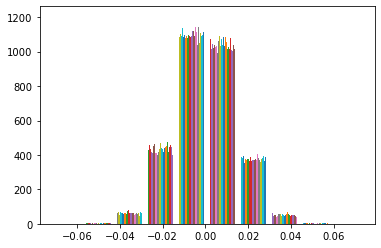

In [6]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure()
plt.hist(list(llmodel.parameters())[0].data.cpu().detach().numpy())
plt.show()

In [6]:
from tqdm import tqdm

NO_EPOCHS = 10

for epoch in range(0, NO_EPOCHS):
    with tqdm(dataloader_train, unit="batch") as tbatch:
        tbatch.set_description(f"Epoch: {epoch}")
        for features, labels in tbatch:
            llmodel.train_step_fast(features.to(device))

Epoch: 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:11<00:00, 17.30batch/s]


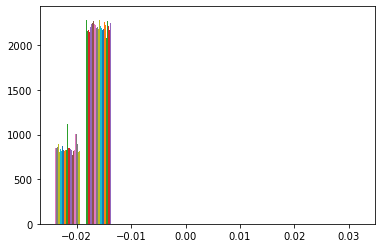

In [7]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure()
plt.hist(list(llmodel.parameters())[0].data.cpu().detach().numpy())
plt.show()

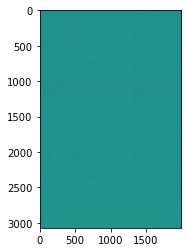

In [15]:
plt.figure()
plt.imshow(list(llmodel.parameters())[0].data.cpu().detach().numpy())
plt.show()

In [8]:
model_path = Path("../data/models/CIFAR10_locallearner.pth")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "model_parameters": model.param_dict(),
        "device_type": device.type
    },
    model_path
)

# Michels Original Code for Comparison

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm_notebook as tqdm
from collections import defaultdict
from torchvision import datasets, transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Define renormalized dataset

In [5]:
# custom imports
from context import LocalLearning

training_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10", train=True, transform=ToTensor(), p=pSet["p"]
)

dataloader_train = DataLoader(
    training_data, batch_size=64, num_workers=10, shuffle=True
)

Files already downloaded and verified


### Parameters

In [6]:
num_pixel = 32**2*3
num_train = len(training_data)
#num_test = x_test.shape[0]
#x_train_flat = x_train.reshape(num_train, num_pixel)
eps0 = 2e-2    # learning rate
Kx = 50
Ky = 50
num_hidden = Kx * Ky    # number of hidden units that are displayed in Ky by Kx array
mu = 0.0
sigma = 1.0
num_epochs = 1    # number of epochs
num_batch = 64      # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

In [7]:
def synaptic_activation(synapses, inputs):
    return (synapses.sign() * synapses.abs() ** (p - 1)).matmul(inputs)

def learning_activation(indices):
    best_ind, best_k_ind = indices[0], indices[k-1]
    g_i = torch.zeros(num_hidden, num_batch).to(device)
    g_i[best_ind,   torch.arange(num_batch).to(device)] = 1.0
    g_i[best_k_ind, torch.arange(num_batch).to(device)] = -delta
    return g_i

### synapses pre training

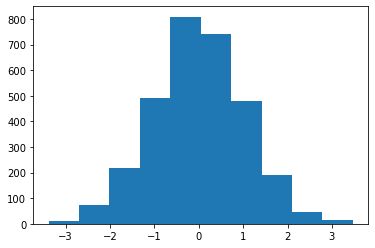

In [8]:
from matplotlib import pyplot as plt
import numpy as np

synapses = torch.Tensor(num_hidden, num_pixel).normal_(mu, sigma).to(device)

pSet = LocalLearning.LocalLearningModel.pSet
pSet["in_size"] = 32**2 * 3 # CIFAR10 consists of 32x32 pixel 3 channel coloured images
pSet["tau_l"] = 1.0 / 0.02 # learning rate 0.04 leads to nans in model.W
pSet["Delta"] = 0.4
pSet["p"] = 2.0
pSet["k"] = 2
pSet["hidden_size"]=2500

llmodel = LocalLearning.LocalLearningModel(pSet)
llmodel.W.copy_(synapses.t().type_as(llmodel.W))
llmodel.to(device)

plt.figure()
plt.hist(list(synapses)[0].data.cpu().detach().numpy())
plt.show()

flat = torch.nn.Flatten()

## compare synaptic activation with forward of own model

In [9]:
features = next(iter(dataloader_train))[0]
kh_activations = llmodel(features.to(device))
flat_features = flat(features.to(device))
mikkel_activations = synaptic_activation(synapses, flat_features.t())

In [10]:
torch.isclose(kh_activations, mikkel_activations.t(), atol=1e-4).all()

tensor(True, device='cuda:0')

In [11]:
print(mikkel_activations.t())

tensor([[-0.7077, -1.2743,  0.4935,  ..., -1.0854,  0.1989, -1.0008],
        [ 0.2770, -0.8454,  0.1819,  ..., -1.2777,  0.3536, -1.0387],
        [-0.6982, -0.8431,  0.9261,  ..., -1.1733, -0.0960, -1.1237],
        ...,
        [-0.4839, -0.5894,  1.0676,  ..., -1.3917,  1.2047, -0.8396],
        [-0.3795, -1.4081,  0.9079,  ..., -1.6565,  0.2722, -0.0080],
        [ 0.4411, -0.4732,  0.7927,  ..., -0.8727,  0.5603, -1.7078]],
       device='cuda:0')


## compare training step

In [12]:
features, _ = next(iter(dataloader_train))
flat_features = flat(features.to(device))

inputs = flat(features.to(device)).t()
# I = <W,v> synaptic activation
tot_input = synaptic_activation(synapses, inputs)
        
# find indices maximizing the synapse
_, indices = tot_input.topk(k, dim=0)
# g(Q) learning activation function
g_i = learning_activation(indices)
# Learning algorithm
xx = (g_i * tot_input).sum(dim=1)
ds = torch.matmul(g_i, inputs.t()) - xx.unsqueeze(1) * synapses
            
nc = max(ds.abs().max(), prec)
            
# the actual update
synapses += eps0 * ds / nc

llmodel.train_step_fast(features.to(device))

tensor(False, device='cuda:0')

In [14]:
llmodel.W

Parameter containing:
tensor([[ 0.7327, -0.3978,  0.3288,  ..., -1.2288,  0.0478,  1.7415],
        [ 0.7046,  1.5602, -0.2764,  ..., -0.2226, -1.5972,  0.6676],
        [ 0.3612,  1.2018, -0.1894,  ..., -0.6520, -0.6730, -0.7418],
        ...,
        [-0.2981, -0.3289, -0.4660,  ...,  1.1980,  0.4838, -1.0197],
        [ 0.0662,  0.0977,  0.5546,  ...,  1.6655,  1.3691, -0.6126],
        [ 1.0909,  0.2696,  0.5048,  ...,  0.1608, -1.3048, -2.5710]],
       device='cuda:0')

In [55]:
# wrap as Tensor
#x_train_flat = torch.Tensor(x_train_flat).to(device)
synapses = torch.Tensor(num_hidden, num_pixel).normal_(mu, sigma).to(device)

flatten = torch.nn.Flatten()

for epoch in range(num_epochs):
    # decay learning rate
    #eps = eps0 * (1 - epoch / num_epochs)
    eps = eps0
    # shuffle data
    #x_train_flat = x_train_flat[torch.randperm(x_train_flat.size(0))]
    
    with tqdm(dataloader_train, unit="batch") as tbatch:
        tbatch.set_description(f"Epoch: {epoch}")
        for features, labels in tbatch:
            
            llmodel.train_step(features.to(device))
        
            inputs = flatten(features.to(device)).t()
            # I = <W,v> synaptic activation
            tot_input = synaptic_activation(synapses, inputs)
        
            # find indices maximizing the synapse
            _, indices = tot_input.topk(k, dim=0)
            # g(Q) learning activation function
            g_i = learning_activation(indices)
            # Learning algorithm
            xx = (g_i * tot_input).sum(dim=1)
            ds = torch.matmul(g_i, inputs.t()) - xx.unsqueeze(1) * synapses
            
            nc = max(ds.abs().max(), prec)
            
            # the actual update
            synapses += eps * ds / nc 
            ###################

  0%|          | 0/50 [00:00<?, ?batch/s]

In [57]:
print(synapses.t())
print(llmodel.W)

tensor([[-1.9860, -0.6130, -0.2619,  ..., -0.8956, -1.9603,  1.0813],
        [-0.9060,  1.6547, -0.5406,  ...,  0.1384,  0.6506,  1.9399],
        [ 1.2824, -0.7907, -0.4279,  ..., -0.2663,  0.2123, -0.5113],
        ...,
        [ 0.1967,  0.0191, -0.8641,  ...,  0.6774, -0.0913, -0.8661],
        [ 1.0513, -0.8550, -1.9851,  ...,  0.5711, -1.5336,  0.8859],
        [-1.1439, -0.5460, -0.0670,  ...,  1.6903,  0.4287,  0.4972]],
       device='cuda:0')
Parameter containing:
tensor([[-0.8693, -0.6820,  3.6572,  ..., -1.3351,  0.2413, -1.0613],
        [-0.3811,  0.8814, -0.4289,  ..., -0.8664, -1.7401, -0.2172],
        [-0.5160,  1.0238, -0.5327,  ...,  0.1398, -0.2293,  1.4742],
        ...,
        [-1.3704, -0.4321, -0.5062,  ...,  1.2766, -0.4406,  0.1247],
        [-0.9504, -0.6080, -0.8008,  ..., -0.5359,  0.3593,  0.7062],
        [-0.8845, -1.3885,  0.3953,  ..., -0.8136,  2.2512, -0.6927]],
       device='cuda:0')


### synapses post training

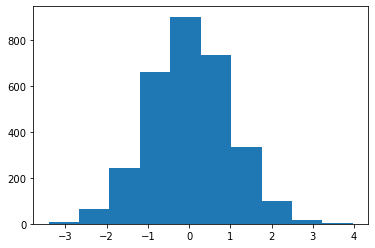

In [43]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure()
plt.hist(list(synapses)[0].data.cpu().detach().numpy())
plt.show()

# Inference and Spectrum

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/CIFAR10_locallearner.pth")

In [3]:
test_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_inference = DataLoader(
    test_data, batch_size=64, num_workers=4, shuffle=False
)

Files already downloaded and verified


In [10]:
with torch.no_grad():
    trained_state = torch.load(model_path)
    model_ps = trained_state["model_parameters"]
    inf_model = LocalLearning.LocalLearningModel(model_ps)
    inf_model.load_state_dict(trained_state["model_state_dict"])
    inf_model.to(device)
    l_spectrum = LocalLearning.Statistics.cov_spectrum(dataloader_inference, inf_model, device)
    cpu = torch.device('cpu')
    l_spectrum = l_spectrum.to(cpu).numpy()

Calculating covariance spectrum: 100%|████████████████████████████████████████████████████████████| 782/782 [00:01<00:00, 424.63batch/s]


Text(0.5, 1.0, 'CIFAR10 Covariance Spectrum')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


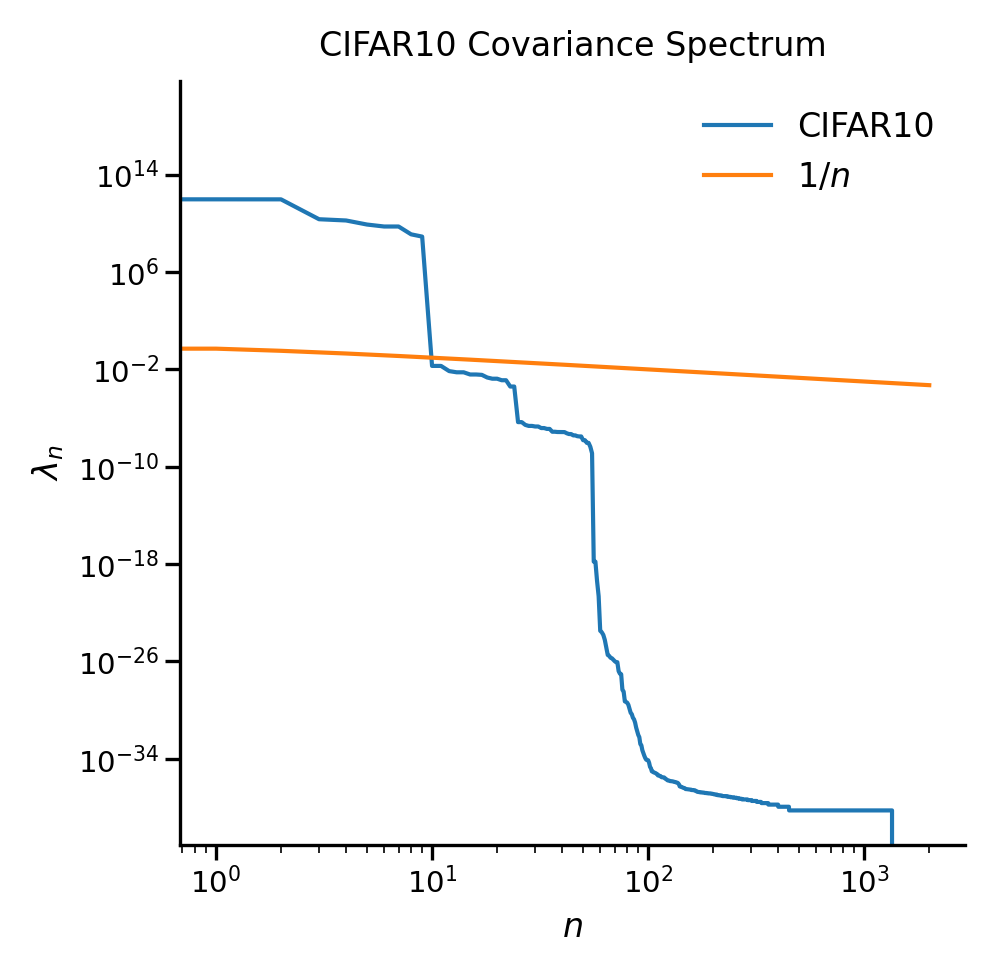

In [11]:
from matplotlib import pyplot as plt
import numpy as np

plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])

fig, ax = plt.subplots()
ax.loglog(l_spectrum, label=r"CIFAR10")
ax.loglog(LocalLearning.stringer_spectrum(np.arange(1, len(l_spectrum))), label=r"$1 / n$")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
ax.set_title(r"CIFAR10 Covariance Spectrum")

# Biological Learning Model

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

from context import LocalLearning

train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/L2UnitCIFAR10_LL/llmodel_L2UnitCIFAR10_5.pth")
ll_trained_state = torch.load(model_path)
bio_model = LocalLearning.BioLearningModel(ll_trained_state)
#bio_model.to(device)
bio_model.train()

BioLearningModel(
  (local_learning): LocalLearningModel(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (softmax): Softmax(dim=-1)
)

In [6]:
from matplotlib import pyplot as plt
import numpy as np

#W_pre_training = bio_model.local_learning.W.clone()
#plt.figure()
#plt.hist(list(bio_model.parameters())[0].data.detach().numpy())
#plt.show()

list(bio_model.parameters())[0]

Parameter containing:
tensor([[-0.0716, -0.0728, -0.0742,  ..., -0.0726, -0.0726, -0.0724],
        [-0.0716, -0.0727, -0.0735,  ..., -0.0720, -0.0724, -0.0724],
        [-0.0721, -0.0733, -0.0737,  ..., -0.0728, -0.0729, -0.0738],
        ...,
        [-0.0627, -0.0643, -0.0633,  ..., -0.0643, -0.0637, -0.0644],
        [-0.0622, -0.0641, -0.0633,  ..., -0.0644, -0.0640, -0.0637],
        [-0.0631, -0.0645, -0.0629,  ..., -0.0646, -0.0642, -0.0631]])

In [28]:
learning_rate = lambda l: 0.02

In [29]:
learning_rate(4.0)

0.02

In [ ]:
import torch.optim 
import numpy as np
from matplotlib import pyplot as plt

#optimizer = torch.optim.Adam(bio_model.parameters(), lr=0.0001)

steps = 0

plt.figure()

for i in range(1):
    for features, labels in dataloader_train:
        #optimizer.zero_grad()
        pred = bio_model(features)
        plt.hist(np.ravel(pred.detach().numpy()), bins=np.linspace(0.0, 1.0, num=20), )
        #print(pred)
        #labels_one_hot = torch.zeros(pred.size())
        #labels_one_hot.scatter_(-1, labels[..., None], 1.0)
        #loss = torch.pow(pred - labels_one_hot, 4.0).sum()
        #loss.backward()
        #optimizer.step()
        steps += 1
        #print(list(bio_model.parameters())[1])
    
print(steps)
plt.show()

In [20]:
W_post = list(bio_model.parameters())[1].data
torch.equal(W_pre, W_post)

True

# End-to-end backpropagation model

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

In [2]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        self.flatten.requires_grad_(False)
        self.hidden = nn.Linear(32*32*3, 2000, bias=False)
        self.hidden.requires_grad_(False)
        self.relu = nn.ReLU()
        self.dense = nn.Linear(2000, 10, bias=False)
        self.relu_two = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x: Tensor) -> Tensor:
        hidden = self.hidden(self.flatten(x))
        activation = torch.pow(self.relu(hidden), 4.5)
        return self.softmax(self.dense(activation))

classifier = Classifier()
classifier.train()

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=3072, out_features=2000, bias=False)
  (relu): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (relu_two): ReLU()
  (softmax): Softmax(dim=-1)
)

In [5]:
train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [6]:
list(classifier.parameters())

[Parameter containing:
 tensor([[-0.0057, -0.0161,  0.0151,  ...,  0.0126,  0.0153, -0.0043],
         [-0.0178, -0.0174, -0.0080,  ..., -0.0031,  0.0024, -0.0178],
         [-0.0128,  0.0065, -0.0057,  ...,  0.0036, -0.0115, -0.0179],
         ...,
         [ 0.0143,  0.0145, -0.0003,  ...,  0.0177,  0.0071, -0.0105],
         [-0.0047,  0.0028, -0.0154,  ...,  0.0027,  0.0038, -0.0042],
         [ 0.0141,  0.0036,  0.0101,  ...,  0.0180,  0.0167,  0.0016]]),
 Parameter containing:
 tensor([[ 0.0110,  0.0190, -0.0184,  ..., -0.0133,  0.0010, -0.0182],
         [ 0.0149,  0.0203,  0.0185,  ..., -0.0199,  0.0076, -0.0182],
         [-0.0079, -0.0096, -0.0169,  ...,  0.0033,  0.0203,  0.0060],
         ...,
         [ 0.0180,  0.0166,  0.0055,  ..., -0.0124, -0.0059, -0.0129],
         [ 0.0084, -0.0085, -0.0119,  ...,  0.0105,  0.0023, -0.0041],
         [ 0.0135,  0.0062,  0.0137,  ...,  0.0090, -0.0057, -0.0153]],
        requires_grad=True)]

In [7]:
import torch.optim 

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

for features, labels in dataloader_train:
    optimizer.zero_grad()
    pred = classifier(features)
    labels_one_hot = torch.zeros(pred.size())
    labels_one_hot.scatter_(-1, labels[..., None], 1.0)
    loss = torch.pow(pred - labels_one_hot, 6.0).sum()
    loss.backward()
    optimizer.step()

In [8]:
list(classifier.parameters())

[Parameter containing:
 tensor([[-0.0057, -0.0161,  0.0151,  ...,  0.0126,  0.0153, -0.0043],
         [-0.0178, -0.0174, -0.0080,  ..., -0.0031,  0.0024, -0.0178],
         [-0.0128,  0.0065, -0.0057,  ...,  0.0036, -0.0115, -0.0179],
         ...,
         [ 0.0143,  0.0145, -0.0003,  ...,  0.0177,  0.0071, -0.0105],
         [-0.0047,  0.0028, -0.0154,  ...,  0.0027,  0.0038, -0.0042],
         [ 0.0141,  0.0036,  0.0101,  ...,  0.0180,  0.0167,  0.0016]]),
 Parameter containing:
 tensor([[-0.1682, -0.0894, -0.1055,  ..., -0.0870, -0.1443, -0.0445],
         [ 0.0597, -0.0100,  0.0443,  ...,  0.1123,  0.0917,  0.0718],
         [-0.0711,  0.0364, -0.1270,  ..., -0.1561, -0.1763, -0.1152],
         ...,
         [ 0.0317,  0.0624,  0.0866,  ..., -0.1071, -0.0031, -0.0434],
         [-0.1795, -0.1541, -0.1571,  ...,  0.0341, -0.0771, -0.0836],
         [ 0.1219, -0.1365,  0.1390,  ..., -0.0028,  0.1732,  0.0729]],
        requires_grad=True)]

{'model_state_dict': OrderedDict([('W',
               tensor([[-0.0741, -0.0739, -0.0741,  ..., -0.0742, -0.0741, -0.0739],
                       [-0.0737, -0.0737, -0.0736,  ..., -0.0736, -0.0738, -0.0737],
                       [-0.0741, -0.0743, -0.0742,  ..., -0.0740, -0.0742, -0.0744],
                       ...,
                       [-0.0646, -0.0644, -0.0645,  ..., -0.0647, -0.0645, -0.0644],
                       [-0.0647, -0.0643, -0.0648,  ..., -0.0645, -0.0644, -0.0647],
                       [-0.0651, -0.0649, -0.0648,  ..., -0.0647, -0.0647, -0.0649]],
                      device='cuda:0'))]),
 'model_parameters': {'in_size': 3072,
  'hidden_size': 2000,
  'n': 4.5,
  'p': 3,
  'tau_l': 5000.0,
  'k': 7,
  'Delta': 0.4,
  'R': 1.0},
 'device_type': 'cuda'}